---
title: " Sampling Bias and Class Imbalance (Oversampling and Undersampling) in Maximum-likelihood Logistic Regression"
sidebar: auto
author:
  - Jumbong Junior 
categories: []
tags: []

title-block-banner: false
format: 
  html: 
    mainfont: Times New Roman
    fontsize: 16pt

jupyter: python3
        
---




# Introduction 

In this article, the impact of sampling bias and class imbalance on logistic regression models is explored. The article covers two topics :

- First, we hypothesize that the predictive performance of a logistic regression model is related to the sampling bias associated with the data and it has a perrformance advantage when the data is balanced. The hypothesis is testing with two simulated datasets : a balanced dataset (50:50) and an imbalanced dataset (80:20).  Each dataset will be sampled to produce samples with the following distribution : 50:50, 60:40, 70:30, 80:20, 90:10, 95:5, 99:1. 

- Second, in the case of class imbalance data, if the oversampling technique is used the intercept of the logistic regression model after oversampling need to be adjusted. In other words, let denote $\hat{\beta_0}$ the intercept of the logistic regression model after oversampling, then the following correction needs to be performed on it : 

$$
\hat{\beta}_0 - \ln\left[\left(\frac{1-\tau}{\tau}\right)\left(\frac{\bar{y}}{1-\bar{y}}\right)\right]
$$

where $\hat{\beta_0}$ is the intercept of the logistic regression model after oversampling, $\tau$ is the proportion of the minority class in the original dataset (or in population), and $\bar{y}$ is the proportion of the minority class in the oversampled dataset (or in sample).

# 1. Simulated Data Generation

Many authors document that, for logistic regressionthe , the probability distribution of the dependent variable is assumed to be Bernoulli and the mass function f is given by :

$$
f(y, x, \alpha, \beta) = p(x, \alpha, \beta)^y(1-p(x, \alpha, \beta))^{1-y}
$$

where 
$$
p(x, \alpha, \beta) = \frac{\exp(\alpha + \beta x)}{1 + \exp(\alpha + \beta x)} 
$$

and where y is the dependent variable, x is the independent variable, $\alpha$ and $\beta$ are the parameters to be estimated using the maximum likelihood method (MLE).

For generating the the bernouilli trial y using for a fixed parameter P, we use the following equation :

$$
y(p) = 
\begin{cases}
\text{dummy} \leftarrow \mathrm{rnd}(1), \\
0, & \text{if dummy} < p, \\
1, & \text{otherwise}.
\end{cases}
$$

where rnd(1) is a random number generator that generates a random number between 0 and 1.

The conditional bernouilli trials y are then generated by substituting of $p(x, \alpha, \beta)$ :

$$
y(x, \alpha, \beta) =
\begin{cases}
0, & \text{if rnd(1)} < p(x, \alpha, \beta), \\
1, & \text{otherwise}.
\end{cases}
$$


In order to generate the data, the following steps will be respected : 
- Generate x the predictor variable from a uniform distribution, which ranges from 0 to 10.
- Choose the parameters $\alpha$ and $\beta$, which will help to genererate the distribution of the dependent variable y.
- Generate the dependent variable y using the logistic function $p(x, \alpha, \beta)$.


## 1.1 Numerical Approach to determine the value of $\beta$

The numerical approach consists to determine, for a given value of $\alpha =-10$, the value of $\beta$ that will allow to have a proportion of y=1 equal to 0.5 in the case of a balanced dataset and 0.2 in the case of an imbalanced dataset.

The optimization problem can be formulated as follows :


$$
\min_{\beta} \left( \text{prop} - \frac{1}{n}\sum_{i=1}^{n} \frac{\exp(\alpha + \beta x_i)}{1 + \exp(\alpha + \beta x_i)} \right)^2 
$$

where $\text{prop}$ is the proportion of y=1 in the dataset, $x_i$ is the predictor variable, and $n$ is the number of observations.

The optimization problem can be solved using the `scipy.optimize.minimize` function with the Nelder-Mead method.


In [1]:
import numpy as np
from scipy.optimize import minimize

# Define the logistic function
def logistic_function(x, alpha, beta):
    return 1 / (1 + np.exp(-(alpha + beta * x)))

# Objective function: minimize the squared difference between mean(pi) and 0.2
def objective(alpha, prop, beta, n):
    x = np.random.uniform(0, 10, n)  # Simulate x values
    pi = logistic_function(x, alpha, beta)
    return (np.mean(pi) - 0.2)**2  # Target mean(pi) = 0.2

# Initial guesses for alpha and beta
initial_params = [0]

# Optimize alpha and beta
result = minimize(lambda params: objective(-10, 0.2, params, 50000), initial_params, method='Nelder-Mead')

# Get optimized alpha and beta
beta_opt = result.x
print(f"Optimized alpha: {-10}, beta: {beta_opt}")

# Generate x and simulate y
x = np.random.uniform(0, 10, 1000)
pi = logistic_function(x, -10, beta_opt)
y = (np.random.uniform(0, 1, 1000) < pi).astype(int)

# Verify proportions
y_mean = np.mean(y)
print(f"Proportion of y=1: {y_mean:.2f}, y=0: {1-y_mean:.2f}")

Optimized alpha: -10, beta: [1.23975]
Proportion of y=1: 0.20, y=0: 0.80


## Simulated Data Generation with $\alpha = -10$ 

The graphical approach consists to fix the value of $\alpha$ for example $\alpha = -10$ and to vary the value of $\beta$ in order to see the suitable distribution of the dependent variable y.

Let's consider two cases :

  - Case A : A balanced dataset with 50:50 distribution of y=0 and y=1.
  - Case B : An imbalanced dataset with 80:20 distribution of y=0 and y=1.

The code below generates the data for the two cases and plots the proportion of y=1 as a function of beta.

The graph @fig-simulate_case_data, both the datasets have a total of 50,000 events, with the Case A dataset having a class distribution of about 50:50 and Case B dataset having a class distribution of about 80:20.


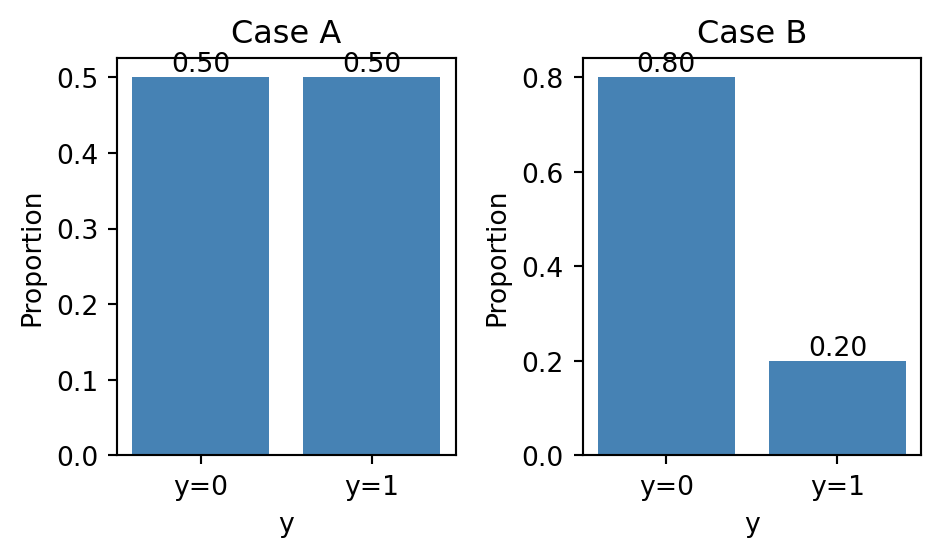

In [2]:
#| label: fig-simulate_case_data
#| fig-cap: 'Simulated data from logistic model with alpha=-10, beta=2 and alpha=-10, beta=beta_opt'

import numpy as np
import matplotlib.pyplot as plt

# Inputs : n_events, alpha, beta, random_state
# Outputs : x, y, prop_y0, prop_y1
# Objective : Simulate data from a logistic model with given alpha, beta.

def simulate_case_data(n_events, alpha, beta, random_state=42):
    """
    Simulate data from a logistic model with given alpha, beta.
    
    x ~ Uniform(0, 10), y ~ Bernoulli(pi(x)), 
    where pi(x) = exp(alpha + beta*x) / (1 + exp(alpha + beta*x)).

    Parameters
    ----------
    n_events : int
        Number of observations (events) to generate.
    alpha : float
        Intercept (alpha) for the logistic function.
    beta : float
        Slope (beta) for the logistic function.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    x : np.ndarray of shape (n_events,)
        Predictor values sampled from Uniform(0,10).
    y : np.ndarray of shape (n_events,)
        Binary outcomes (0 or 1) from Bernoulli trials.
    prop_y0 : float
        Proportion of y==0 in the dataset.
    prop_y1 : float
        Proportion of y==1 in the dataset.
    """
    np.random.seed(random_state)
    
    # 1) Draw x from Uniform(0,10)
    x = np.random.uniform(0, 10, size=n_events)
    
    # 2) Compute pi(x, alpha, beta)
    logit = alpha + beta*x
    pi = np.exp(logit) / (1.0 + np.exp(logit))
    
    # 3) Generate y via Bernoulli(pi)
    dummy = np.random.rand(n_events)
    y = (dummy < pi).astype(int)
    
    # 4) Calculate proportions of 0 and 1
    prop_y0 = np.mean(y == 0)
    prop_y1 = np.mean(y == 1)
    
    return x, y, prop_y0, prop_y1

# ---------------- Example usage ----------------


# Case A: alpha=-10, beta=2 --> expected ~50:50 distribution
xA, yA, p0_A, p1_A = simulate_case_data(
    n_events=50000,
    alpha=-10,
    beta=2,
    random_state=42
)

# Case B: alpha=-10, beta=3.85 --> expected ~80:20 distribution
xB, yB, p0_B, p1_B = simulate_case_data(
    n_events=50000,
    alpha=-10,
    beta=beta_opt,
    random_state=42
)

# Verify proportions

# Suppose p0_A, p1_A, p0_B, p1_B are already defined
# e.g., p0_A = 0.50; p1_A = 0.50; p0_B = 0.80; p1_B = 0.20

fig, axes = plt.subplots(1, 2, figsize=(5, 3))  # 1 row, 2 columns

# -------- LEFT SUBPLOT: Case A -----------
ax1 = axes[0]
bar_container_A = ax1.bar(['y=0', 'y=1'], [p0_A, p1_A], color=['steelblue', 'steelblue'])
ax1.set_title('Case A')
ax1.set_xlabel('y')
ax1.set_ylabel('Proportion')
ax1.bar_label(bar_container_A, fmt='%.2f')

# -------- RIGHT SUBPLOT: Case B -----------
ax2 = axes[1]
bar_container_B = ax2.bar(['y=0', 'y=1'], [p0_B, p1_B], color=['steelblue', 'steelblue'])
ax2.set_title('Case B')
ax2.set_xlabel('y')
ax2.set_ylabel('Proportion')
ax2.bar_label(bar_container_B, fmt='%.2f')

plt.tight_layout()  # improves spacing
plt.show()


The theoretical properties of the simulated datasets are presented in @fig-plot_logit_vs_x. The left subplot shows the probability of y=1 as a function of x for Case A and Case B. The right subplot shows the logit function as a function of x for Case A and Case B. The logit function is given by $\alpha + \beta x$.


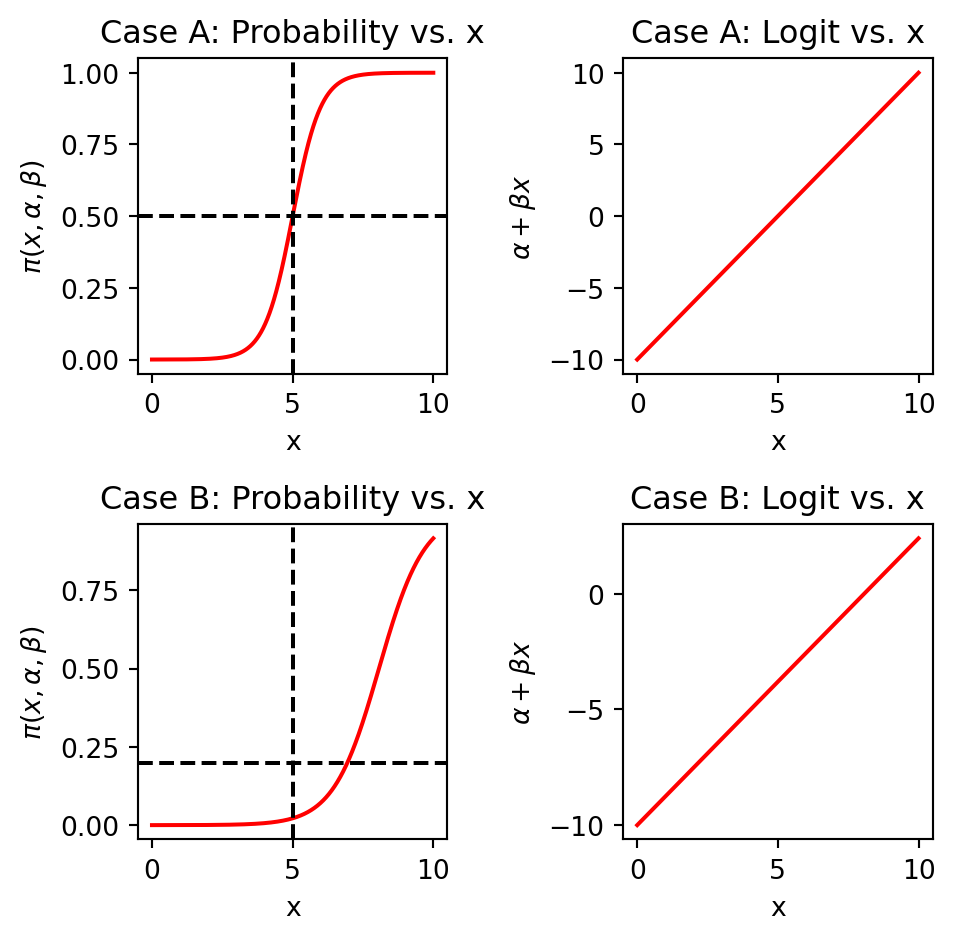

In [3]:
#| label: fig-plot_logit_vs_x
#| fig-cap: Logit vs. x for Case A and Case B
import numpy as np
import matplotlib.pyplot as plt

def logistic(x, alpha, beta):
    return np.exp(alpha + beta*x) / (1.0 + np.exp(alpha + beta*x))

x_values = np.linspace(0, 10, 50000)

# Case A
alpha_A, beta_A = -10, 2
pi_A = logistic(x_values, alpha_A, beta_A)
logit_A = alpha_A + beta_A * x_values

# Case B
alpha_B, beta_B = -10, beta_opt
pi_B = logistic(x_values, alpha_B, beta_B)
logit_B = alpha_B + beta_B * x_values

fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# (a) Probability vs. x for Case A
axes[0, 0].plot(x_values, pi_A, 'r')
axes[0, 0].set_title('Case A: Probability vs. x')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel(r'$\pi(x,\alpha,\beta)$')  # <-- raw string
# Add horizontal line at y=0.5 and vertical line at x= 5
axes[0, 0].axhline(y=0.5, color='k', linestyle='--')
axes[0, 0].axvline(x=5, color='k', linestyle='--')
# (b) Logit vs. x for Case A
axes[0, 1].plot(x_values, logit_A, 'r')
axes[0, 1].set_title('Case A: Logit vs. x')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel(r'$\alpha + \beta x$')      # <-- raw string

# (c) Probability vs. x for Case B
axes[1, 0].plot(x_values, pi_B, 'r')
axes[1, 0].set_title('Case B: Probability vs. x')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel(r'$\pi(x,\alpha,\beta)$')  # <-- raw string
# Add horizontal line at y=0.5 and vertical line at x= 5
axes[1, 0].axhline(y=0.2, color='k', linestyle='--')
axes[1, 0].axvline(x=5, color='k', linestyle='--')

# (d) Logit vs. x for Case B
axes[1, 1].plot(x_values, logit_B, 'r')
axes[1, 1].set_title('Case B: Logit vs. x')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel(r'$\alpha + \beta x$')      # <-- raw string

plt.tight_layout()
plt.show()

# Methodology

To test the hypothesis that sampling bias controls the optimal class balance required for the best predictive performance of maximum-likelihood logistic regression, samples will be drawn from the two datasets (Case A and Case B) with varying class distributions. The class distributions will be as follows: 50:50, 60:40, 70:30, 80:20, 90:10, 95:5, and 99:1, respectively.

For each each class sample distribution, 1000 monte-carlo simulations will be carried out and for each simulation the maximum-likelihood logistic regression model will be fitted. The predictive performance of the model will be evaluated using AUC(Area Under the Curve), AU-PCR(Area Under the Precision-Recall Curve), Precision, Recall, F1-score. Those metrics are computed from elements of the confusion matrix : True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN). The confusion matrix is the matrix with the observed in columns and the predicted in rows. 

# Results

## Case A : Balanced Dataset

The Case A dataset has a balanced class distribution of 50:50. This will be the true distribution of the dataset. Eight random samples will be extracted from the Case A population with varying class distributions of 50:50, 60:40, 70:30, 80:20, 90:10, 95:5, and 99:1. 
A sample with a class distributiion of 60:40 from the Case A is referred as $A_{60:40}$.
The sample size for each of the eight samples is determinded by fixing the lenght of the majority class (class 0) at 5000. In order word, for the $A_{60:40}$ sample, the number of observations in class 0 is 5000 and the number of observations in class 1 is :

$$
\text{Number of observations in class 1} = \frac{40}{60} \times 5000 = 3333
$$

### Eight sub-samples generated from Case A.

The code below generates the eight sub-samples from the Case A dataset with varying class distributions. 


In [4]:
# Case A: Balanced dataset
# Inputs : dependent variable y_A, independent variable x_A, majority_class_size0 = 5000, fraction_class0 = 0.5, random_state = 42
# Outputs : X_sub, y_sub

def create_subsample_fixed_majority(
    X, y, 
    fraction_class0=0.6,  # e.g., 0.6 => 60:40
    majority_class0_size=5000,
    random_state=42
):
    """
    Extract a subsample where the number of class-0 = majority_class0_size,
    and overall fraction of class-0 is fraction_class0.
    
    Returns X_sub, y_sub.
    """
    np.random.seed(random_state)
    
    # Indices of class 0 and 1 in the population
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]
    
    # We fix #class0 = 5000
    n0 = majority_class0_size
    
    # fraction_class0 = n0 / (n0 + n1) => n1 = n0 * (1 - p)/p
    p = fraction_class0
    n1 = int(round(n0 * (1 - p) / p))
    
    chosen_0 = np.random.choice(idx_0, size=n0, replace=False)
    chosen_1 = np.random.choice(idx_1, size=n1, replace=False)
    
    chosen_indices = np.concatenate([chosen_0, chosen_1])
    np.random.shuffle(chosen_indices)
    
    return X[chosen_indices], y[chosen_indices]

The code below generates the eight sub-samples from the Case A dataset with varying class distributions.


In [5]:
# Module : Generation
# Inputs : fraction_class0 = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], create_subsample_fixed_majority.
# Ourputs : A dictionnarie with keys in fraction_class0 and values a tuple (X_sub, y_sub).

fractions_class0 = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.98, 0.99]

samples_A = {}
for frac0 in fractions_class0:
    X_sub, y_sub = create_subsample_fixed_majority(
        xA, yA, 
        fraction_class0=frac0, 
        majority_class0_size=5000,
        random_state=42
    )
    # Store or process each sample
    samples_A[frac0] = (X_sub, y_sub)
    
    # Print actual distribution
    actual_n0 = np.sum(y_sub == 0)
    actual_n1 = np.sum(y_sub == 1)
    print(f"Desired ratio {int(frac0*100)}:{int((1-frac0)*100)}",
          f" => #class0={actual_n0}, #class1={actual_n1}, total={len(y_sub)}",
          f" => ratio0={actual_n0/len(y_sub):.3f}, ratio1={actual_n1/len(y_sub):.3f}")

Desired ratio 50:50  => #class0=5000, #class1=5000, total=10000  => ratio0=0.500, ratio1=0.500
Desired ratio 60:40  => #class0=5000, #class1=3333, total=8333  => ratio0=0.600, ratio1=0.400
Desired ratio 70:30  => #class0=5000, #class1=2143, total=7143  => ratio0=0.700, ratio1=0.300
Desired ratio 80:19  => #class0=5000, #class1=1250, total=6250  => ratio0=0.800, ratio1=0.200
Desired ratio 90:9  => #class0=5000, #class1=556, total=5556  => ratio0=0.900, ratio1=0.100
Desired ratio 95:5  => #class0=5000, #class1=263, total=5263  => ratio0=0.950, ratio1=0.050
Desired ratio 98:2  => #class0=5000, #class1=102, total=5102  => ratio0=0.980, ratio1=0.020
Desired ratio 99:1  => #class0=5000, #class1=51, total=5051  => ratio0=0.990, ratio1=0.010


A maximum-likelihood logistic regression model will be fitted to each of the eight sub-samples. A plot of the true $p(x)$ versus the estimated $p(x)$ is presented in @fig-plot_true_vs_estimated_p_A.


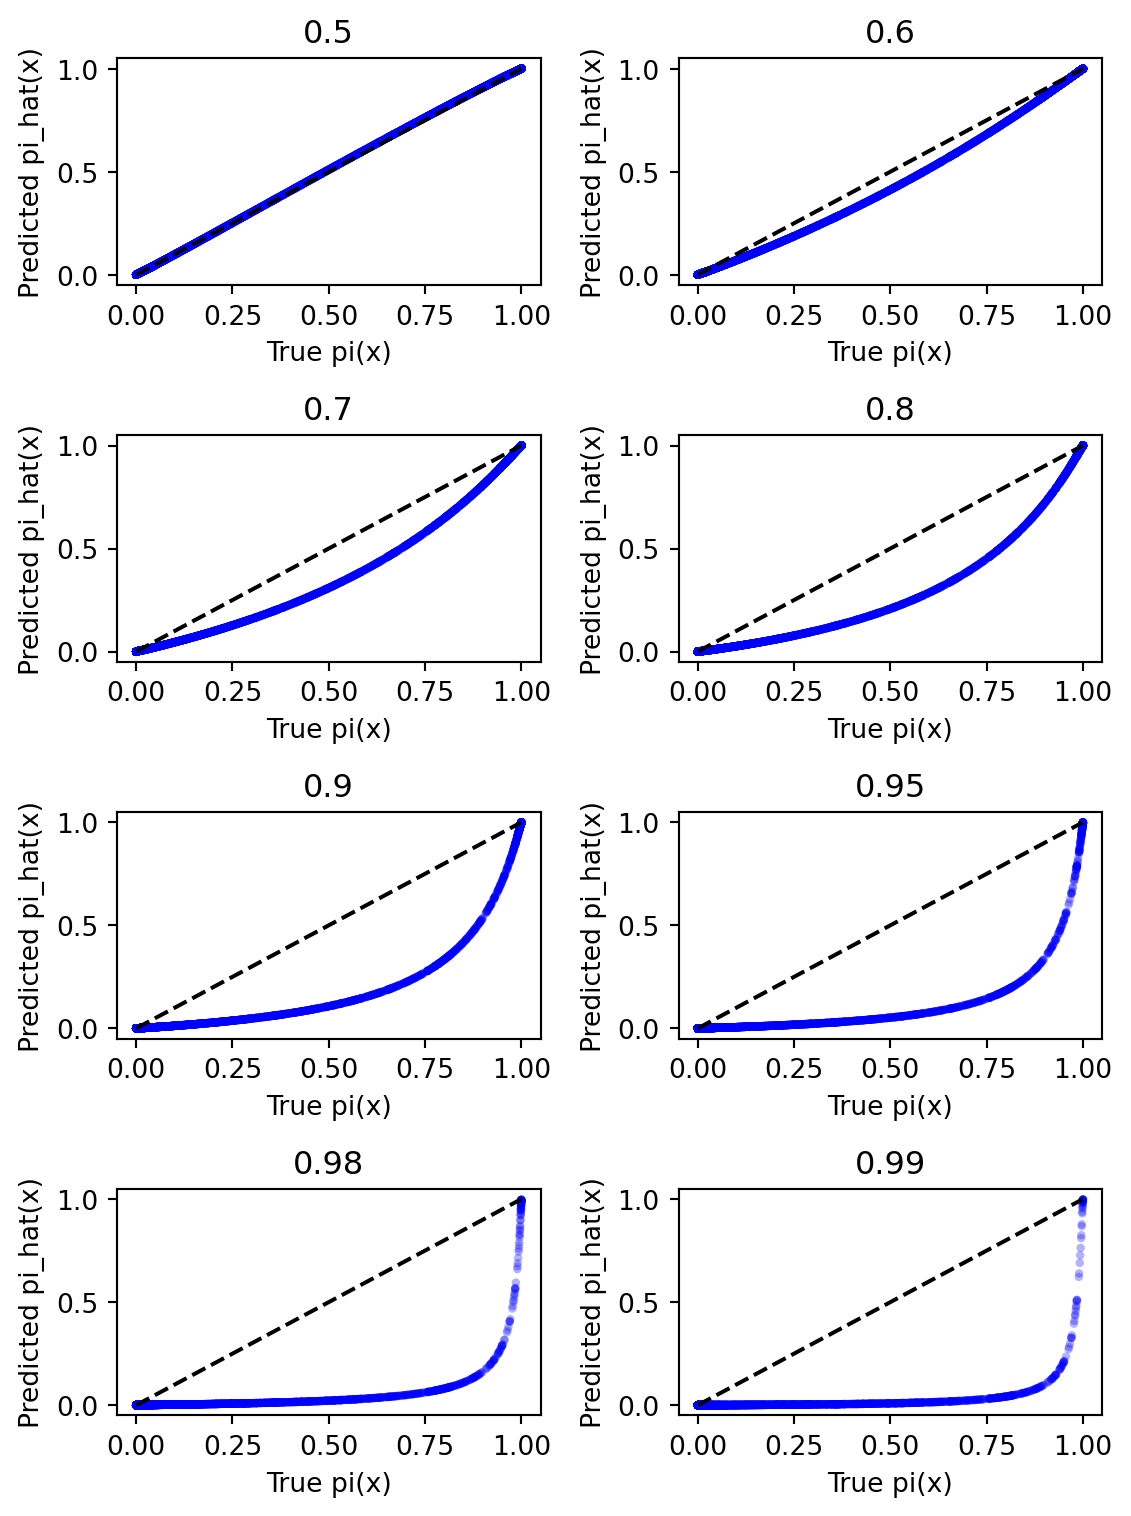

In [6]:
#| label: fig-plot_true_vs_estimated_p_A
#| fig-cap: True vs. estimated p(x) for Case A sub-samples

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Inputs : samples_A, fractions_class0
# Outputs : fig




# For illustration, let's create a 2 x 4 grid to show all eight ratio-samples
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6,8))
axes = axes.ravel()  # flatten into 1D array [ax0, ax1, ..., ax7]

# Hardcode alpha=-10, beta=2 for "true" logistic in Case A
ALPHA_TRUE = -10
BETA_TRUE  = 2

for i, (label, (X_sub, y_sub)) in enumerate(samples_A.items()):
    ax = axes[i]
    
    # 1) Put the data into a DataFrame for convenience
    df_sub = pd.DataFrame({
        'X': X_sub,       # predictor
        'y': y_sub        # binary outcome
    })
    
    # 2) Add a constant column for the intercept in statsmodels
    df_sub = sm.add_constant(df_sub, has_constant='add')  
    # Now df_sub has columns ['const', 'X', 'y']
    
    # 3) Fit the logistic model
    model = sm.Logit(df_sub['y'], df_sub[['const', 'X']])
    results = model.fit(disp=False)  # disp=False to suppress output
    
    # 4) Predict the fitted probability
    df_sub['pi_pred'] = results.predict(df_sub[['const', 'X']])
    
    # 5) Compute the "true" pi for comparison
    df_sub['pi_true'] = logistic(df_sub['X'].values, alpha=ALPHA_TRUE, beta=BETA_TRUE)
    
    # 6) Plot pi_true vs. pi_pred
    ax.scatter(df_sub['pi_true'], df_sub['pi_pred'], 
               alpha=0.3, s=10, color='blue', edgecolors='none')
    # Add a diagonal line for reference
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    # 7) Decorate the subplot
    ax.set_xlabel("True pi(x)")
    ax.set_ylabel("Predicted pi_hat(x)")
    ax.set_title(f"{label}")  # e.g., "Case A60:40"

plt.tight_layout()
plt.show()

### Distribution of the performance metrics for the eight sub-samples from Case A with monte-carlo simulations.

We perform 1000 monte-carlo simulations for each of the eight sub-samples from Case A. For each simulation, we fit a maximum-likelihood logistic regression model and compute the performance metrics : AUC, AU-PCR, Precision, Recall, F1-score. In order words, in the end of this exercise, we will have 1000 values for each of the performance metrics for each of the eight sub-samples. It can be necessary to plot the boxplot of the performance metrics for each of the eight sub-samples in order to see the distribution of the performance metrics.


In [7]:
#| label: fig-plot_boxplot_metrics_A
#| fig-cap: Boxplot of performance metrics for Case A sub-samples

from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score
)

def evaluate_model_performance(y_true, y_proba, threshold=0.5):
    """
    Given true labels and predicted probabilities, compute AUC, AU-PRC,
    Precision, Recall, and F1 at a chosen threshold.
    """
    # 1) AUC (ROC)
    auc = roc_auc_score(y_true, y_proba)
    
    # 2) AU-PRC (average precision)
    auprc = average_precision_score(y_true, y_proba)
    
    # 3) Convert probas -> hard predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # 4) Precision, Recall, F1
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    
    return auc, auprc, prec, rec, f1

from sklearn.model_selection import train_test_split

MC_RUNS = 1000
SAMPLE_SIZE = 5000  # e.g., majority class size if using a fixed majority approach
ratios = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.98, 0.99]
results_list = []

for r in ratios:
    for mc_i in range(MC_RUNS):
        # 1) Create a random subsample
        #    Use None or vary random_state so each iteration is unique
        X_sub, y_sub = create_subsample_fixed_majority(
            xA, yA,
            fraction_class0=r,
            majority_class0_size=SAMPLE_SIZE,
            random_state=None
        )
        
        # 2) Split the subsample into train/test
        #    stratify ensures class distribution is preserved
        X_train, X_test, y_train, y_test = train_test_split(
            X_sub,
            y_sub,
            test_size=0.3,
            random_state=None,
            stratify=y_sub
        )
        
        # Prepare DataFrame for the training set
        df_train = pd.DataFrame({'X': X_train, 'y': y_train})
        df_train = sm.add_constant(df_train, prepend=True, has_constant='add')  
        # => columns: ['const', 'X', 'y']
        
        # 3) Fit logistic regression on the TRAIN portion
        logit_model = sm.Logit(df_train['y'], df_train[['const', 'X']])
        result = logit_model.fit(disp=False)
        
        # 4) Predict probabilities on the TEST portion
        df_test = pd.DataFrame({'X': X_test})
        df_test = sm.add_constant(df_test, prepend=True, has_constant='add')
        
        y_proba_test = result.predict(df_test[['const', 'X']])
        
        # 5) Evaluate performance metrics on the TEST set
        auc, auprc, prec, rec, f1 = evaluate_model_performance(y_test, y_proba_test, threshold=0.5)
        
        # 6) Store results
        results_list.append({
            'ratio_0': r,
            'auc': auc,
            'auprc': auprc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })

# Convert collected results to a DataFrame
df_results = pd.DataFrame(results_list)
df_results.head()

,ratio_0,auc,auprc,precision,recall,f1
0,0.5,0.984476,0.985404,0.931034,0.936000,0.933511
1,0.5,0.985727,0.986211,0.937500,0.940000,0.938748
2,0.5,0.984336,0.984814,0.920290,0.931333,0.925779
3,0.5,0.983796,0.984537,0.929755,0.935333,0.932536
4,0.5,0.983269,0.984283,0.936906,0.920667,0.928716


The boxplot of the performance metrics for each of the eight sub-samples from Case A is presented in @fig-plot_boxplot_metrics_A.


auc          0.001589
auprc        0.001545
precision    0.006483
recall       0.006717
f1           0.004613
dtype: float64
auc          0.001755
auprc        0.002362
precision    0.008411
recall       0.009588
f1           0.006181
dtype: float64
auc          0.002114
auprc        0.003868
precision    0.011293
recall       0.013452
f1           0.008585
dtype: float64
auc          0.002445
auprc        0.006459
precision    0.015740
recall       0.018729
f1           0.012289
dtype: float64
auc          0.003667
auprc        0.014884
precision    0.026294
recall       0.032764
f1           0.022354
dtype: float64
auc          0.004841
auprc        0.027349
precision    0.040148
recall       0.053183
f1           0.036904
dtype: float64
auc          0.007862
auprc        0.057292
precision    0.069784
recall       0.085910
f1           0.067407
dtype: float64
auc          0.012285
auprc        0.100613
precision    0.113049
recall       0.131319
f1           0.110737
dtype: float64


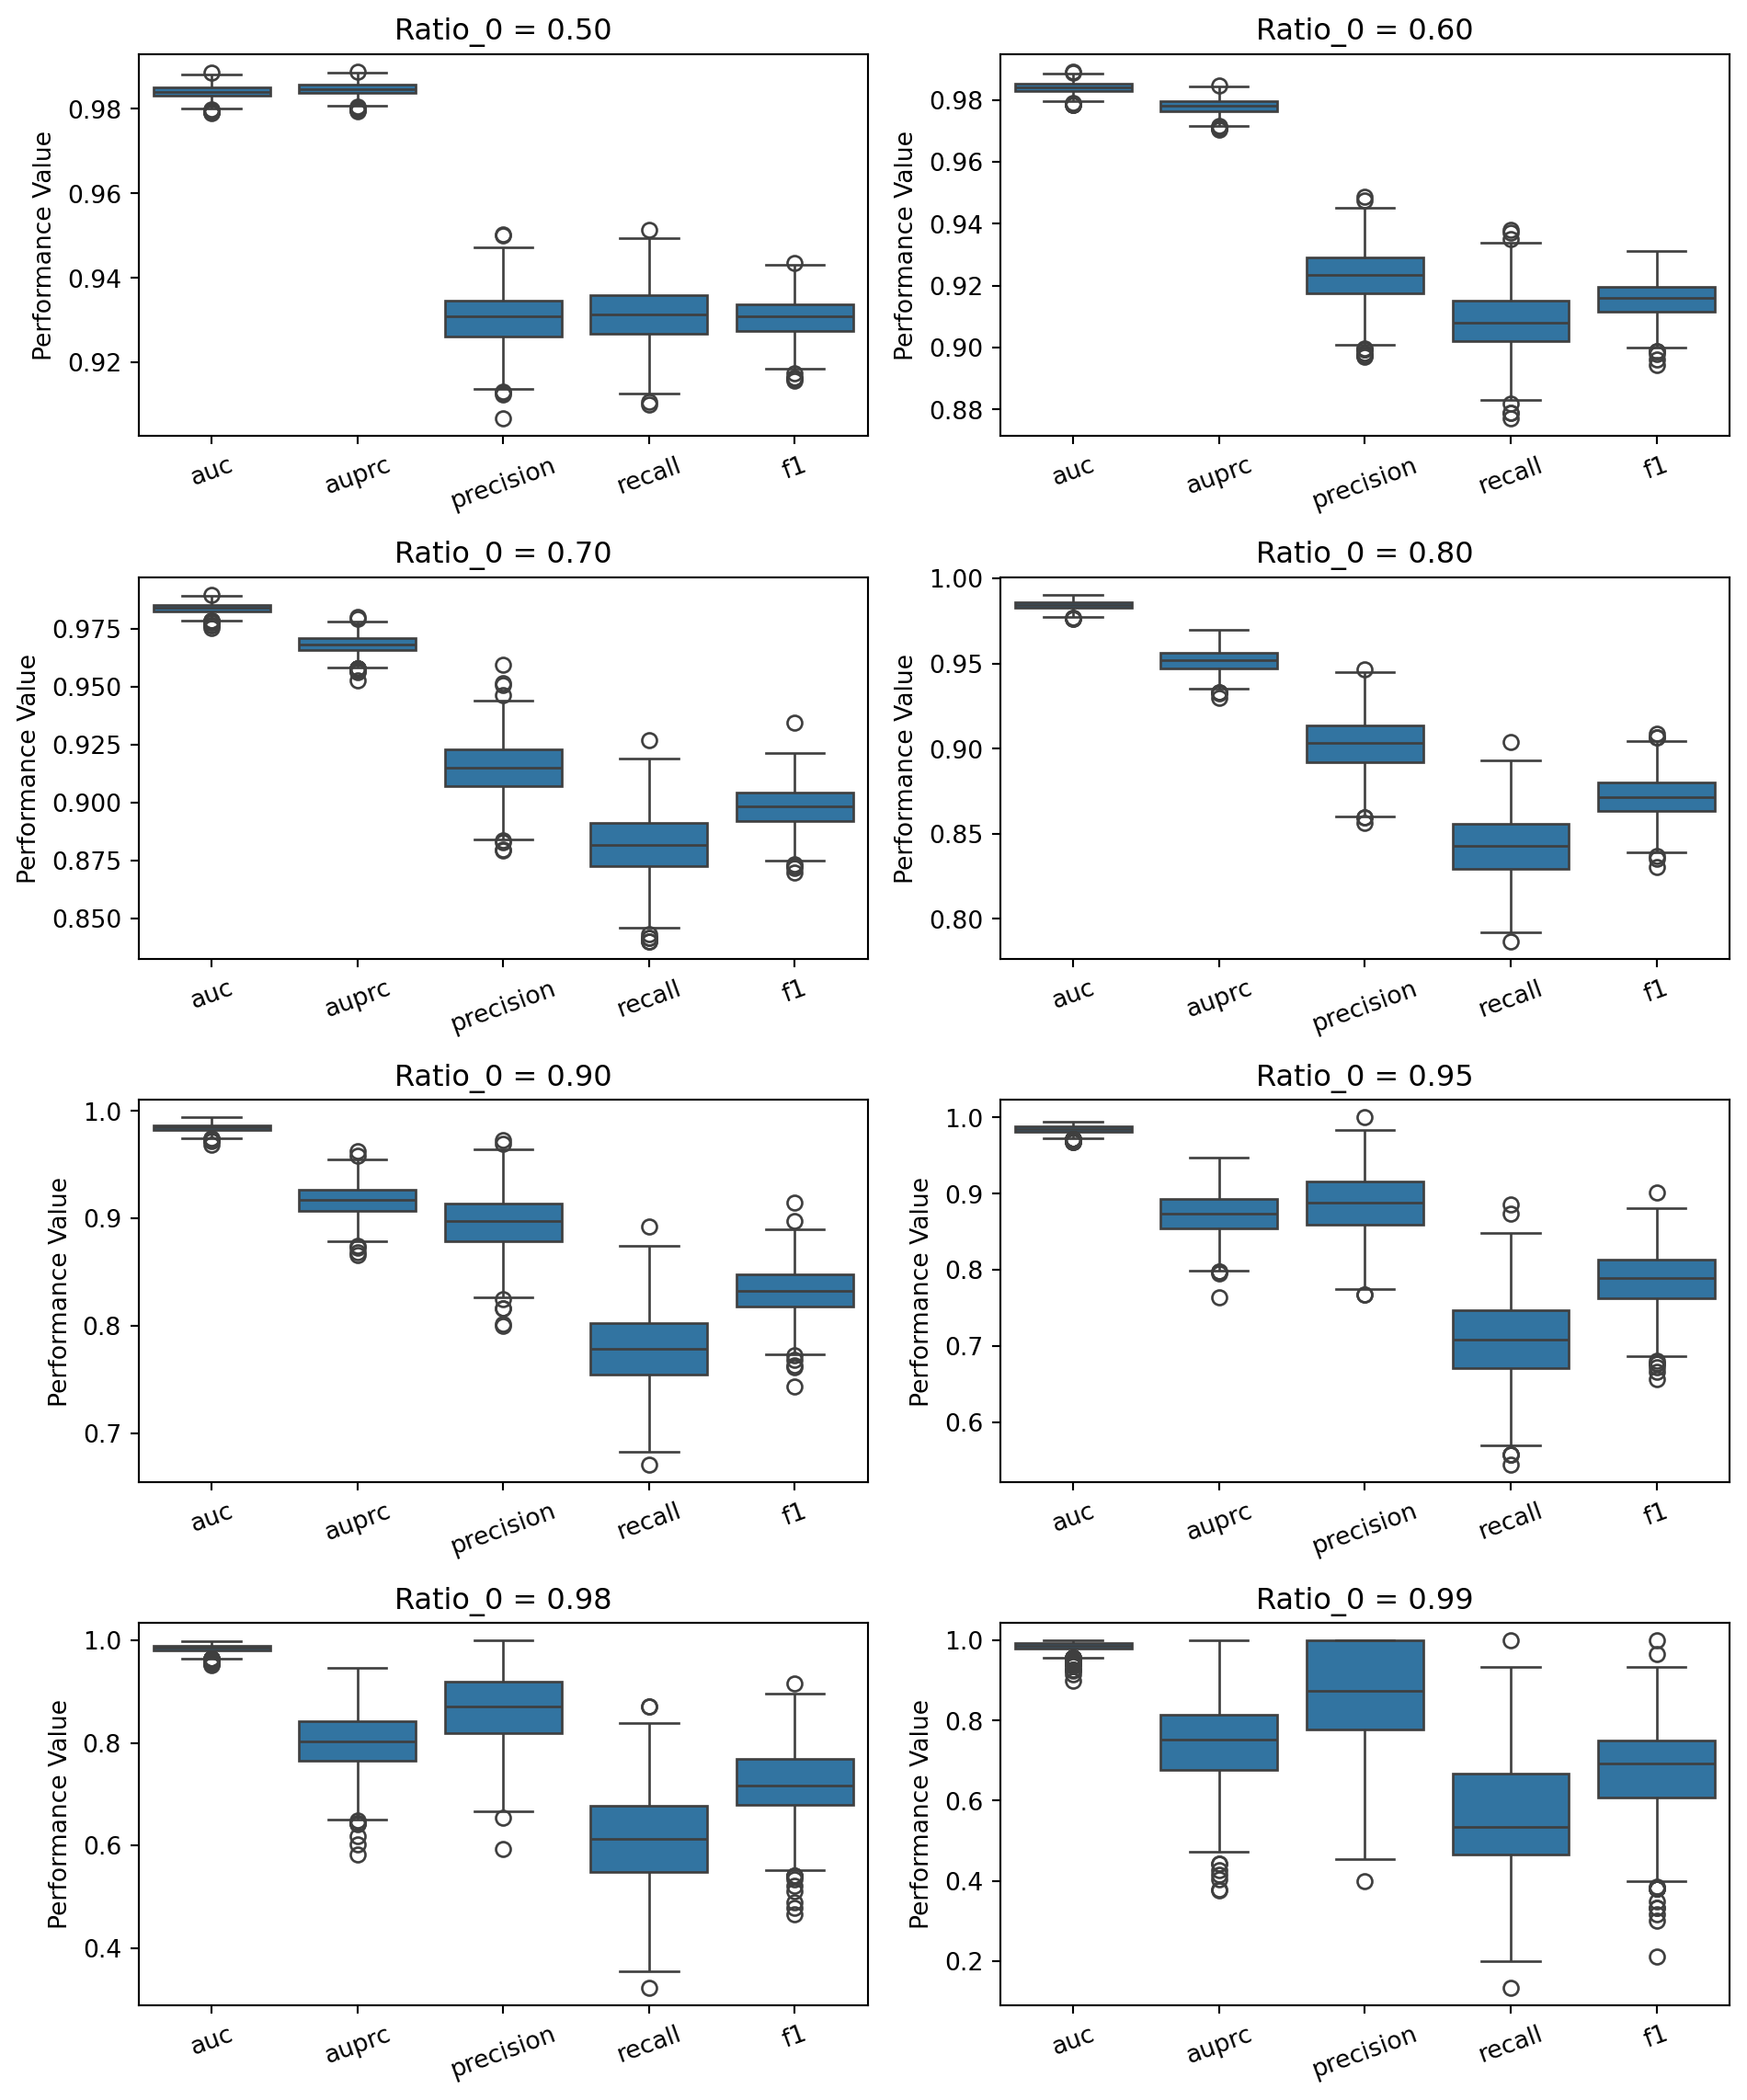

In [8]:
#| label: fig-plot_boxplot_metrics_A
#| fig-cap: Boxplot of performance metrics for Case A sub-samples

# Module : Plotting
# Inputs : df_results, ratios
# Outputs : a boxplot 4x2 of the performances metrics for each ratio.
# Objective : Filter the results for each ratio and plot the boxplot of the performance metrics. the results must be fig, axes = plt.subplots(4,2, figsize=(10,12)).
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose 'df_results' contains columns: ratio_0, auc, auprc, precision, recall, f1
# Suppose 'ratios' = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.98, 0.99]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.ravel()  # Flatten (4x2) -> (8,)

metrics = ['auc', 'auprc', 'precision', 'recall', 'f1']  # which metrics to show

for i, ratio in enumerate(ratios):
    ax = axes[i]
    
    # Filter df_results for the current ratio
    df_ratio = df_results[df_results['ratio_0'] == ratio]
    print(df_ratio[['auc','auprc','precision','recall','f1']].std()
)
    # We can make a new df that includes only the metrics we want
    # For instance, to get boxplot of [auc, auprc, precision, recall, f1]:
    # one approach: melt the dataframe so we have columns: [metric, value]
    df_melt = df_ratio[metrics].melt(var_name='Metric', value_name='Value')
    
    # Create a boxplot on this subplot
    sns.boxplot(data=df_melt, x='Metric', y='Value', ax=ax)
    
    ax.set_title(f"Ratio_0 = {ratio:.2f}")
    ax.set_xlabel("")
    ax.set_ylabel("Performance Value")
    # Optionally rotate x-labels if you have many metrics
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()